In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
# import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# from tensorflow import keras
import keras
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers.core import Reshape
from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.cudnn_recurrent import CuDNNLSTM
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
yscaler = StandardScaler()

In [2]:
close_df = pd.read_csv('../res/close_df.csv',index_col=0)
close_df.head()

df = np.log(close_df).diff()
target = df['XAU'].iloc[2:].values
features = df.iloc[1:-1].values

train_val_split = 6000
train_test_split = 7500

X_train = scaler.fit_transform(features[:train_val_split])
y_train = target[:train_val_split].reshape(-1,1)

X_val = scaler.transform(features[train_val_split:train_test_split])
y_val = target[train_val_split:train_test_split].reshape(-1,1)

X_test = scaler.transform(features[train_test_split:])
y_test = target[train_test_split:].reshape(-1,1)

In [10]:
def return_loss(y_true, y_pred):
    # pos = K.sign(y_pred)
    loss = -K.mean(y_pred * y_true)
    return loss

model = load_model('dnn_32_16.h5',custom_objects={'return_loss':return_loss})

In [23]:
# On the test set
test_df = pd.DataFrame()
test_df['y_true'] = y_test.flatten()
test_df['y_pred'] = model.predict(X_test).flatten()
test_df['label_true'] = test_df['y_true'].apply(lambda x: 1 if x > 0 else 0)
test_df['label_pred'] = test_df['y_pred'].apply(lambda x: 1 if x > 0 else 0)
test_df['correct'] = 1
test_df['correct'][test_df['label_true']!=test_df['label_pred']] = 0

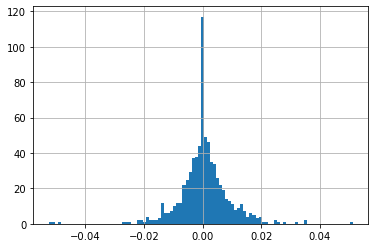

In [21]:
test_df['y_true'].hist(bins=100)

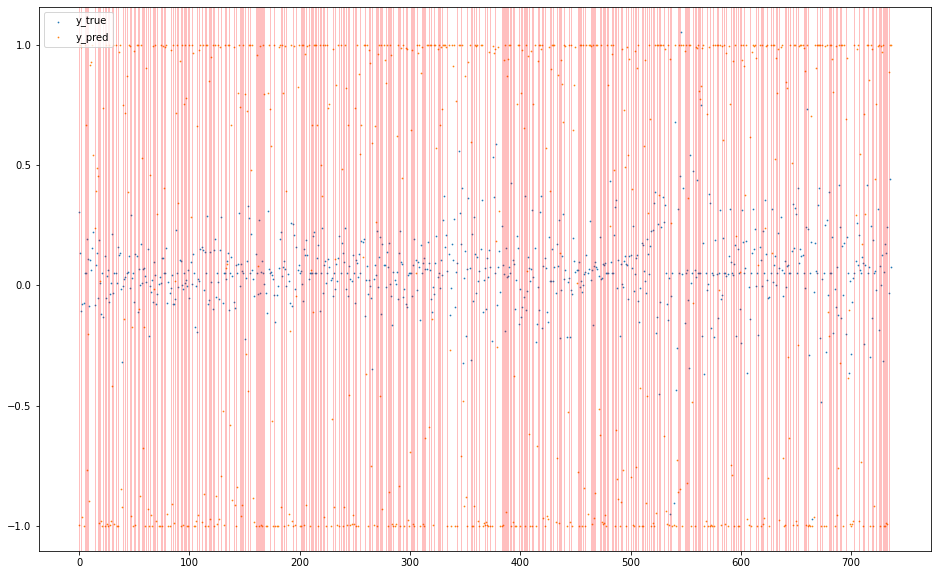

In [41]:
# Part 1 单点预测失效
plt.figure(figsize=(16,10))
plt.scatter(test_df.index, (test_df['y_true']/ test_df['y_true'].max() - test_df['y_true'].min()),s=0.5)
plt.scatter(test_df.index, test_df['y_pred'],s=0.5)
plt.legend(['y_true','y_pred'])
for x in test_df[test_df['correct']==0].index:
    plt.axvline(test_df.index[x], color='r',linewidth=0.5,alpha=0.5)
plt.show()

In [84]:
# Part 2 区域性失效：给定窗口，收益不及预期
window = 50
step = 20
test_df['exp_rt'] = test_df['y_true'].rolling(window).sum() 
test_df['exp_rt'][test_df['exp_rt']<0] = 0
test_df['real_rt'] = (test_df['correct'].apply(lambda x: x if x == 1 else -1) * test_df['y_true']).rolling(window).sum()
test_df['fail'] = test_df[['exp_rt','real_rt']].apply(lambda x: 1 if x['real_rt']<x['exp_rt'] else 0,axis=1)

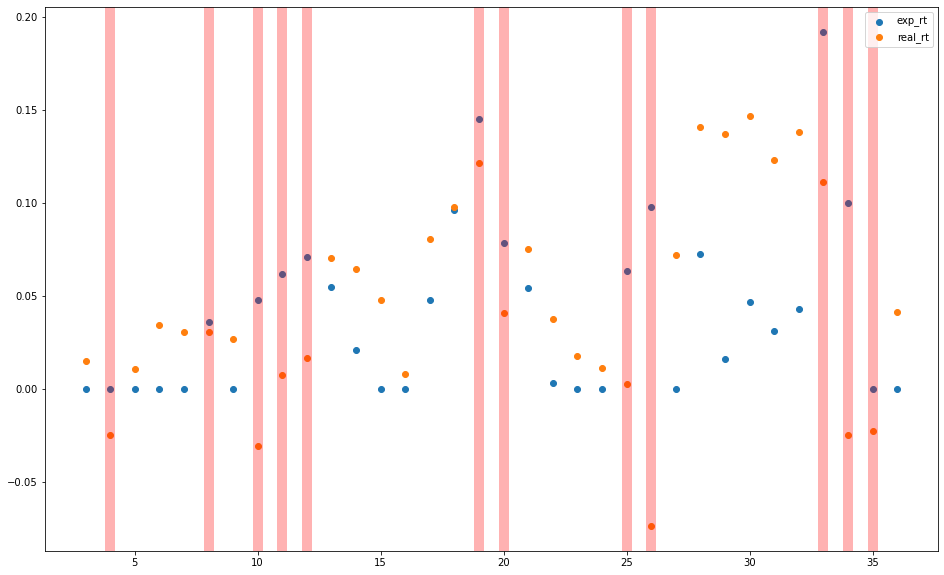

Failure rate: 32.43%


In [85]:
draw_df = test_df[['exp_rt','real_rt','fail']][::step].reset_index(drop=True)
plt.figure(figsize=(16,10))
plt.scatter(draw_df.index, draw_df['exp_rt'])
plt.scatter(draw_df.index, draw_df['real_rt'])
plt.legend(['exp_rt','real_rt'])
for x in draw_df[draw_df['fail']==1].index:
    plt.axvline(draw_df.index[x], color='r',linewidth=10,alpha=0.3)
plt.show()
print(f'Failure rate: {100*draw_df.fail.mean():.2f}%')

Failure rate: 51.35%


In [ ]:
# Part 3 区域性失效：回归判定？
# 线性回归：技术指标 + 预测值 ~ 实际值